# Thousang grain weight (TGW(g)) - Mass prediction studies for faba bean seeds

Author: Harpreet Kaur Bargota

Date: Dec 23, 2025


## Import the libraries and read the ground truth .csv file

In [1]:
#import the libraries required for analysis
import pandas as pd
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
# import functions from sklearn
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, explained_variance_score)
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
#Read the hand and machine measured data
Mass_pred = pd.read_excel("../Groundtruth_data/Faba_Seed_Analyzer_Data_August_2024.xlsx", sheet_name= "Mean S2 Seed Data")

In [3]:
# display the head
Mass_pred.head(4)

,ID,Main Seed,Main Seeds,Weight(g),TGW(g),Seeds/kg,"""B-Stocking""/Non-Seeds",Date,Time,ØArea,...,Max Width,Max Length,Volume(ml),Volume Weight(kg/hl),ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio
0,Vf1-1-2,Vicia faba,4,4.8877,1221.925000,818.380834,8,13/06/2023,14:38,219.500247,...,14.532204,21.097440,15,32.584667,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772
1,Vf4-1-1,Vicia faba,6,1.9316,321.933333,3106.233175,7,13/06/2023,14:40,54.012175,...,8.224431,10.592581,15,12.877333,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690
2,Vf7-1-1,Vicia faba,10,3.5681,356.810000,2802.612034,9,13/06/2023,14:42,65.235907,...,8.462456,11.367768,15,23.787333,1.164687,1.135995,1.187734,1.351447,1.251236,1.429181
3,Vf8-1-1,Vicia faba,9,3.8984,433.155556,2308.639442,9,13/06/2023,14:43,70.955747,...,9.208415,12.489041,15,25.989333,1.161806,1.151720,1.179324,1.317772,1.249530,1.399287


In [4]:
# check the columns
Mass_pred.columns

Index(['ID', 'Main Seed', 'Main Seeds', 'Weight(g)', 'TGW(g)', 'Seeds/kg',
       '"B-Stocking"/Non-Seeds', 'Date', 'Time', 'ØArea', 'ØWidth', 'ØLength',
       'Min Width', 'Min Length', 'Max Width', 'Max Length', 'Volume(ml)',
       'Volume Weight(kg/hl)', 'ØCircularity', 'Min Circularity',
       'Max Circularity', 'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio'],
      dtype='object')

## Data and Features: Get the necessary columns from dataframe 

### Use all the categorical and numerical values for predicting TGW(g) 

In [5]:
Mp1=Mass_pred[['ID', 'Main Seeds', 'Weight(g)', 'TGW(g)', 'Seeds/kg',
       'ØArea', 'ØWidth', 'ØLength', 'Min Width', 'Min Length', 'Max Width', 'Max Length',
        'ØCircularity', 'Min Circularity',
       'Max Circularity', 'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio']]

In [6]:
Mp1.head(4)

,ID,Main Seeds,Weight(g),TGW(g),Seeds/kg,ØArea,ØWidth,ØLength,Min Width,Min Length,Max Width,Max Length,ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio
0,Vf1-1-2,4,4.8877,1221.925000,818.380834,219.500247,14.314509,19.600875,13.820892,17.850534,14.532204,21.097440,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772
1,Vf4-1-1,6,1.9316,321.933333,3106.233175,54.012175,7.435900,9.232743,6.420532,7.520082,8.224431,10.592581,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690
2,Vf7-1-1,10,3.5681,356.810000,2802.612034,65.235907,7.909650,10.681146,7.491855,9.937081,8.462456,11.367768,1.164687,1.135995,1.187734,1.351447,1.251236,1.429181
3,Vf8-1-1,9,3.8984,433.155556,2308.639442,70.955747,8.330176,10.984360,7.683458,9.743898,9.208415,12.489041,1.161806,1.151720,1.179324,1.317772,1.249530,1.399287


The dataset contains multiple predictor variables (features) and one target variable- TGW(g). 
The features used in the study are:
Numerical Features:
•Main Seeds, ØArea, ØWidth, ØLength, Min Width, Min Length, Max Width, Max Length, ØCircularity, Min Circularity, Max Circularity, ØL/W Ratio, Min L/W Ratio, Max L/W Ratio

Categorical Features:
•ID (used for one-hot encoding)

Target Variable: TGW(g)



## Methodology


### Make pipeline to preprocess the data

In [7]:
features = ['ID', 'Main Seeds', 'ØArea', 'ØWidth', 'ØLength', 'Min Width', 'Min Length', 'Max Width', 'Max Length',
            'ØCircularity', 'Min Circularity', 'Max Circularity', 'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio']
target = 'TGW(g)'

X = Mp1[features]
y = Mp1[target]

To facilitate preprocessing of a dataset with mixed data types, use the make_column_selector utility from the sklearn.compose module. This approach allows for dynamic selection of columns based on their data types, which is particularly useful in machine learning pipelines where categorical and numerical features often require different preprocessing steps.
cat_selector: This selector identifies all columns in the dataset X that contain object-type data, typically representing categorical variables.
num_selector: This selector identifies all columns with numeric data types (e.g., integers and floats), which are typically used for numerical analysis and modeling.
cat_selector(X): This line applies the categorical selector to the dataset X, returning a list of column names that contain categorical data. This output can then be used to apply specific preprocessing steps such as one-hot encoding or imputation.
num_selector(X): Selects columns with numeric data types such as int64 and float64.

In [8]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

['ID']

In [9]:
num_selector(X)

['Main Seeds',
 'ØArea',
 'ØWidth',
 'ØLength',
 'Min Width',
 'Min Length',
 'Max Width',
 'Max Length',
 'ØCircularity',
 'Min Circularity',
 'Max Circularity',
 'ØL/W Ratio',
 'Min L/W Ratio',
 'Max L/W Ratio']

### Design the pipeline required for the tree-based models.
This preprocessing pipeline is designed for tree-based models. It uses an OrdinalEncoder to convert categorical variables into integers, handling unknown values with -1 and missing values with -2. For numerical features, a SimpleImputer fills missing values with the mean and adds indicators for missing entries. These steps are combined using make_column_transformer, applying each processor to the appropriate columns selected by num_selector and cat_selector. This setup ensures the data is clean and model-ready.

In [10]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE910CE510>)])

## Define the preprocessor (oneHotencoding and normalization) Steps
This pipeline prepares data for linear models by one-hot encoding categorical features and scaling numerical ones. It uses OneHotEncoder to handle unknown categories and a pipeline of StandardScaler and SimpleImputer to normalize and impute missing numerical values. These steps are combined using make_column_transformer for efficient preprocessing.


In [11]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE910CE510>)])

## Stack of predictors on the data set

### Linear regression
Machine learning pipeline for linear regression is created by combining preprocessing and modeling steps. The linear_pipeline uses make_pipeline to sequentially apply the linear_preprocessor, which prepares the data by encoding categorical features and scaling/imputing numerical ones, followed by fitting a LinearRegression model. This streamlined approach ensures that all necessary data transformations are applied consistently during both training and prediction, improving model reliability and simplifying deployment.

In [12]:
linear_pipeline = make_pipeline(linear_preprocessor, LinearRegression())
linear_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE910CE510>)])),
                ('linearregression', LinearRegression())])

### Random forest regression
After preprocessing, the data is passed to a RandomForestRegressor with a fixed random_state for reproducibility. 

In [13]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE910CE510>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Gradient boosting
Machine learning pipeline for regression using a Gradient Boosting model is created as explained with the above models.


In [14]:
gbr_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(random_state=0))
gbr_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE910CE510>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=0))])

### Stacking regressor
To enhance regression performance, we implemented a stacked ensemble model using StackingRegressor. This method combines multiple diverse base models—Random Forest, Linear Regression, and Gradient Boosting—each encapsulated in its own preprocessing pipeline. These pipelines ensure that data is appropriately transformed for each model type, with tree-based models using ordinal encoding and imputation, and the linear model using one-hot encoding and scaling.
The outputs of these base models are then used as input features for a final estimator, RidgeCV, which is a regularized linear regression model with built-in cross-validation. This final model learns the optimal way to combine the predictions of the base models, leveraging their complementary strengths. The stacking approach is particularly effective when the base models capture different aspects of the data, leading to improved accuracy and robustness over any single model.

In [15]:
estimators = [
    ("Random Forest", rf_pipeline),
    ("Linear regression", linear_pipeline),
    ("Gradient Boosting", gbr_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unkno...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE90FF2AD0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CE910CE510>)])),
                                               ('gradientboostingregressor',
                                                GradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

## Training and testing on the original dataset
To evaluate and compare the performance of multiple regression models, including a stacked ensemble, a systematic cross-validation and visualization process was implemented. A copy of the original dataset was created to store model predictions. A 2x2 grid of subplots was defined to visualize prediction errors for each model. For each estimator—Random Forest, Linear Regression, Gradient Boosting, and the Stacking Regressor—cross-validation was performed using cross_validate to compute R² and MAE scores. Out-of-fold predictions were generated using cross_val_predict and stored in the dataset for further analysis.
Model performance was visualized using PredictionErrorDisplay, which plots actual versus predicted values to assess prediction accuracy and bias. Each plot was annotated with evaluation metrics and computation time, providing a comprehensive view of each model’s effectiveness. This methodology ensures fair comparison across models and highlights the potential benefits of model stacking in regression tasks.

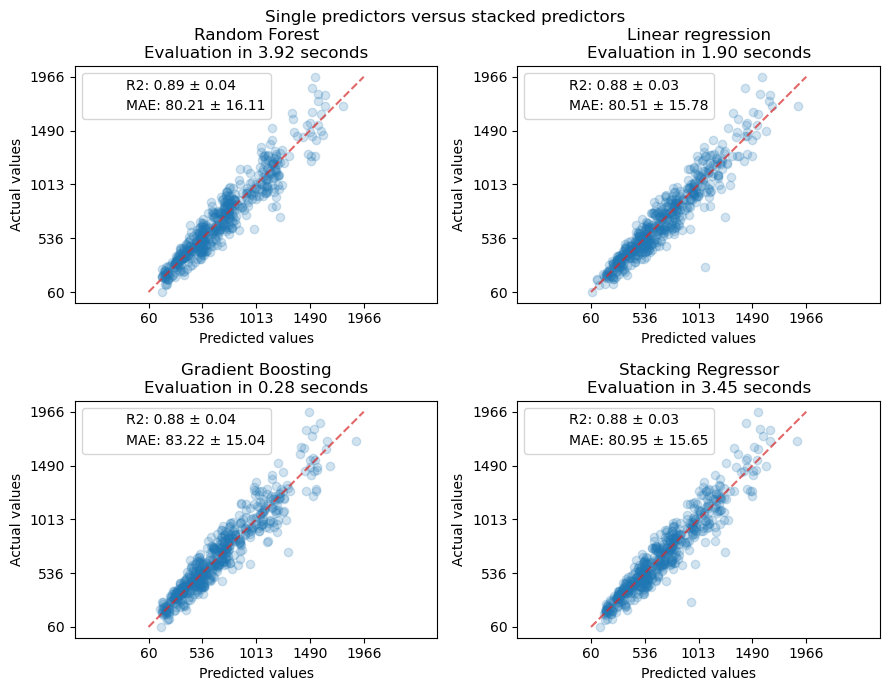

In [16]:
# Copy of the original dataframe to store predictions
df_pred = Mp1.copy()

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    # Add predictions to the DataFrame with a clear column name
    col_name = f"y_pred_{name.replace(' ', '_').lower()}"
    df_pred[col_name] = y_pred

    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} ± "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for metric_name, score_text in scores.items():
        ax.plot([], [], " ", label=f"{metric_name}: {score_text}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("Manymodels_MP.JPG", format="jpg", dpi=300)
plt.show()


Interpretation
1. Random Forest achieved the highest R² score (0.89), indicating the best fit to the data among the models. It also had a relatively low MAE, suggesting good predictive accuracy.
2. Linear Regression performed nearly as well in terms of R² and MAE, but with a significantly faster evaluation time (0.05 seconds), making it highly efficient for quick predictions.
3. Gradient Boosting had slightly lower performance metrics and a longer evaluation time than Linear Regression, offering no clear advantage.
4. Stacking Regressor matched Linear Regression in R² and MAE but had the longest evaluation time.

In [17]:
df_pred.head(2)

,ID,Main Seeds,Weight(g),TGW(g),Seeds/kg,ØArea,ØWidth,ØLength,Min Width,Min Length,...,ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio,y_pred_random_forest,y_pred_linear_regression,y_pred_gradient_boosting,y_pred_stacking_regressor
0,Vf1-1-2,4,4.8877,1221.925000,818.380834,219.500247,14.314509,19.600875,13.820892,17.850534,...,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772,1194.501419,1221.240166,1179.753375,1197.337027
1,Vf4-1-1,6,1.9316,321.933333,3106.233175,54.012175,7.435900,9.232743,6.420532,7.520082,...,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690,297.278900,294.239034,261.776236,292.767439


# Comparison studies for selecting a model for TGW(g) prediction

In [18]:
# from sklearn.inspection import permutation_importance
# import matplotlib.pyplot as plt
# import numpy as np

# # -----------------------------
# # FUNCTION: Plot feature importances
# # -----------------------------

# def plot_feature_importance(importances, feature_names, title, figsize=(8, 6), filename=None):
#     importances = np.array(importances)
#     feature_names = np.array(feature_names)

#     # Sort by importance
#     sorted_idx = np.argsort(importances)
#     sorted_importances = importances[sorted_idx]
#     sorted_features = feature_names[sorted_idx]

#     # Convert to percentage
#     pct = 100 * (sorted_importances / sorted_importances.sum())

#     plt.figure(figsize=figsize)
#     bars = plt.barh(sorted_features, pct)

#     # Add % labels
#     for bar, val in zip(bars, pct):
#         plt.text(
#             bar.get_width() + 0.3,     # small offset
#             bar.get_y() + bar.get_height() / 2,
#             f"{val:.1f}%",            # format percentage
#             va="center",
#             fontsize=9
#         )

#     plt.xlabel("Feature Importance (%)")
#     plt.title(title)
#     plt.tight_layout()

#     if filename:
#         plt.savefig(filename, dpi=300, format="jpg")
#     plt.show()

# # ----------------------------------------
# # GET PROCESSED FEATURE NAMES FROM PIPELINE
# # ----------------------------------------
# def get_feature_names(preprocessor, feature_list):
#     """Extract final feature names after column transformer."""
#     output = []
#     transformers = preprocessor.transformers_

#     for name, trans, cols in transformers:
#         if name == 'remainder':
#             continue

#         if hasattr(trans, "named_steps"):
#             # pipeline inside ColumnTransformer
#             step = list(trans.named_steps.values())[-1]
#         else:
#             step = trans

#         if hasattr(step, "get_feature_names_out"):
#             step_names = step.get_feature_names_out(cols)
#         else:
#             step_names = cols

#         output.extend(step_names)
#     return output

# # -----------------------------
# # COMPUTE AND PLOT IMPORTANCES
# # -----------------------------

# # Random Forest Importances
# rf_model = rf_pipeline.fit(X, y)
# rf_feature_names = get_feature_names(tree_preprocessor, features)
# rf_importances = rf_model.named_steps['randomforestregressor'].feature_importances_

# plot_feature_importance(
#     rf_importances,
#     rf_feature_names,
#     "Random Forest Feature Importance",
#     filename="RF_feature_importance.jpg"
# )

# # Gradient Boosting Importances
# gbr_model = gbr_pipeline.fit(X, y)
# gbr_feature_names = get_feature_names(tree_preprocessor, features)
# gbr_importances = gbr_model.named_steps['gradientboostingregressor'].feature_importances_

# plot_feature_importance(
#     gbr_importances,
#     gbr_feature_names,
#     "Gradient Boosting Feature Importance",
#     filename="GBR_feature_importance.jpg"
# )

# # ----------------------------------------------------------
# # Stacking Regressor Permutation Importance (most reliable)
# # ----------------------------------------------------------
# stacking_model = stacking_regressor.fit(X, y)

# perm_result = permutation_importance(
#     stacking_model, X, y, n_repeats=10, random_state=42, n_jobs=-1
# )

# stack_feature_names = get_feature_names(tree_preprocessor, features)

# plot_feature_importance(
#     perm_result.importances_mean,
#     stack_feature_names,
#     "Stacking Regressor — Permutation Importance",
#     filename="Stacking_feature_importance.jpg"
# )

# # ----------------------------------------------------------
# # OPTIONAL: Linear Regression Coefficient Plot
# # ----------------------------------------------------------
# lin_model = linear_pipeline.fit(X, y)
# lin_feature_names = get_feature_names(linear_preprocessor, features)
# lin_coefs = lin_model.named_steps['linearregression'].coef_

# plot_feature_importance(
#     np.abs(lin_coefs),
#     lin_feature_names,
#     "Linear Regression Coefficient Magnitudes",
#     filename="Linear_regression_coefficients.jpg"
# )


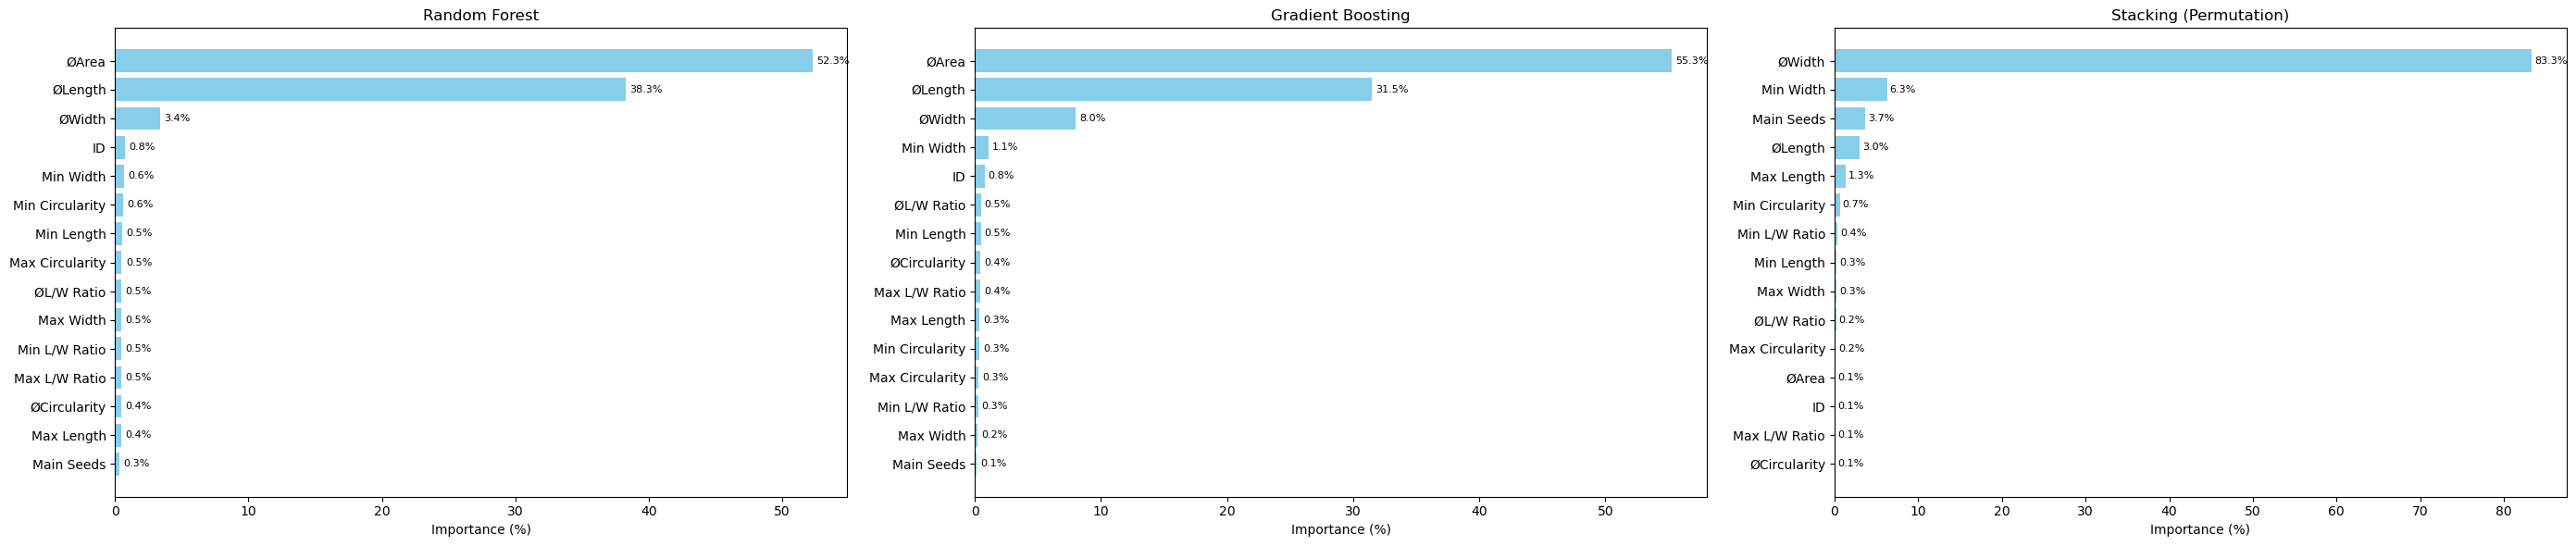

In [19]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# FUNCTION: Plot feature importances in a given axis
# -----------------------------
def plot_feature_importance_ax(ax, importances, feature_names, title):
    importances = np.array(importances)
    feature_names = np.array(feature_names)

    # Sort by importance
    sorted_idx = np.argsort(importances)
    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]

    # Convert to percentage
    pct = 100 * (sorted_importances / sorted_importances.sum())

    bars = ax.barh(sorted_features, pct, color='skyblue')

    # Add % labels
    for bar, val in zip(bars, pct):
        ax.text(
            bar.get_width() + 0.3,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}%",
            va="center",
            fontsize=8
        )

    ax.set_xlabel("Importance (%)")
    ax.set_title(title)

# ----------------------------------------
# GET PROCESSED FEATURE NAMES FROM PIPELINE
# ----------------------------------------
def get_feature_names(preprocessor, feature_list):
    """Extract final feature names after column transformer."""
    output = []
    transformers = preprocessor.transformers_

    for name, trans, cols in transformers:
        if name == 'remainder':
            continue

        if hasattr(trans, "named_steps"):
            step = list(trans.named_steps.values())[-1]
        else:
            step = trans

        if hasattr(step, "get_feature_names_out"):
            step_names = step.get_feature_names_out(cols)
        else:
            step_names = cols

        output.extend(step_names)
    return output

# -----------------------------
# FIT MODELS AND GET IMPORTANCES
# -----------------------------
rf_model = rf_pipeline.fit(X, y)
gbr_model = gbr_pipeline.fit(X, y)
stacking_model = stacking_regressor.fit(X, y)
lin_model = linear_pipeline.fit(X, y)

rf_importances = rf_model.named_steps['randomforestregressor'].feature_importances_
gbr_importances = gbr_model.named_steps['gradientboostingregressor'].feature_importances_

perm_result = permutation_importance(stacking_model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
stack_importances = perm_result.importances_mean

lin_coefs = np.abs(lin_model.named_steps['linearregression'].coef_)

rf_feature_names = get_feature_names(tree_preprocessor, features)
gbr_feature_names = get_feature_names(tree_preprocessor, features)
stack_feature_names = get_feature_names(tree_preprocessor, features)
lin_feature_names = get_feature_names(linear_preprocessor, features)

# -----------------------------
# PLOT ALL IN ONE ROW
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(28, 6))

plot_feature_importance_ax(axes[0], rf_importances, rf_feature_names, "Random Forest")
plot_feature_importance_ax(axes[1], gbr_importances, gbr_feature_names, "Gradient Boosting")
plot_feature_importance_ax(axes[2], stack_importances, stack_feature_names, "Stacking (Permutation)")
# plot_feature_importance_ax(axes[3], lin_coefs, lin_feature_names, "Linear Regression")

plt.tight_layout()
plt.savefig("All_feature_importances.jpg", dpi=300)
plt.show()


### Test data preparation for SAM2.1-generated data for Prediction studies
The test data was extracted in the same format as the original training data.

In [20]:
#read the .csv file for SAM2.1 data
SAM2=pd.read_csv(r"C:\Users\bargotah\Downloads\output_nov27\FE_Color.csv")

SAM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Seed No. per image          4234 non-null   int64  
 1   Class                       4234 non-null   object 
 2   Area-SAM(mm2)               4234 non-null   float64
 3   Length-SAM(mm)              4234 non-null   float64
 4   Width-SAM(mm)               4234 non-null   float64
 5   Perimeter-SAM(mm)           4234 non-null   float64
 6   Area-SAM_taubin(mm2)        4234 non-null   float64
 7   Length-SAM_taubin(mm)       4234 non-null   float64
 8   Width-SAM_taubin(mm)        4234 non-null   float64
 9   Perimeter-SAM_taubin(mm)    4234 non-null   float64
 10  Area-SAM_minEnc(mm2)        4234 non-null   float64
 11  Length-SAM_minEnc(mm)       4234 non-null   float64
 12  Width-SAM_minEnc(mm)        4234 non-null   float64
 13  Perimeter-SAM_minEnc(mm)    4234 

In [21]:
# Extract the value after the last underscore for column ``ÎD`` for column ``Class``
SAM2['ID'] = SAM2['Class'].str.split('_').str[-1]

# print the first 2 rows of df
print (SAM2.head(2))

   Seed No. per image                   Class  Area-SAM(mm2)  Length-SAM(mm)  \
0                   0  Faba-Seed-CC_Vf447-1-1      96.047573       11.248159   
1                   1  Faba-Seed-CC_Vf447-1-1      90.111920       10.808319   

   Width-SAM(mm)  Perimeter-SAM(mm)  Area-SAM_taubin(mm2)  \
0      10.770226          34.610325             94.820851   
1      10.496649          33.291382             88.961008   

   Length-SAM_taubin(mm)  Width-SAM_taubin(mm)  Perimeter-SAM_taubin(mm)  ...  \
0              12.447068              9.756425                 37.090704  ...   
1              11.960346              9.508600                 35.677237  ...   

   Compactness  Circularity-SAM                             Shape  \
0     0.882754         1.154560  Elongated,Oval,Elongated,Ellipse   
1     0.889838         1.138604  Elongated,Oval,Elongated,Ellipse   

   Shapefactor1  Shapefactor2  Shapefactor3  Shapefactor4  RGB value of Seed  \
0      0.005105      0.004002      0.779255

In [22]:
# get the df with the required features
SAM2_1=SAM2[['Seed No. per image', 'ID', 'Area-SAM_taubin(mm2)', 'Length-SAM_taubin(mm)', 'Width-SAM_taubin(mm)','Circularity-SAM','Aspect Ratio']]
print (SAM2_1.head(10))

   Seed No. per image         ID  Area-SAM_taubin(mm2)  Length-SAM_taubin(mm)  \
0                   0  Vf447-1-1             94.820851              12.447068   
1                   1  Vf447-1-1             88.961008              11.960346   
2                   2  Vf447-1-1             88.740168              12.034672   
3                   3  Vf447-1-1             93.780177              12.901503   
4                   4  Vf447-1-1            102.147924              12.562562   
5                   5  Vf447-1-1            109.945418              14.514539   
6                   6  Vf447-1-1             99.084893              13.337874   
7                   0  Vf498-1-1            132.737335              14.980025   
8                   1  Vf498-1-1            130.251986              14.865348   
9                   2  Vf498-1-1            136.663116              15.473414   

   Width-SAM_taubin(mm)  Circularity-SAM  Aspect Ratio  
0              9.756425         1.154560      1.275

### Feature engineering: 
Since the original data had the average data, new coulmns were created which should have the average data for each bean line.

In [23]:
# create a new df with the required average data for each parameter
new_df = (
    SAM2_1.groupby('ID').agg(
        **{
            'Main Seeds':        ('Seed No. per image', 'count'),
            'ØArea':             ('Area-SAM_taubin(mm2)', 'mean'),
            'ØWidth':            ('Width-SAM_taubin(mm)', 'mean'),
            'ØLength':           ('Length-SAM_taubin(mm)', 'mean'),
            'Min Width':         ('Width-SAM_taubin(mm)', 'min'),
            'Min Length':        ('Length-SAM_taubin(mm)', 'min'),
            'Max Width':         ('Width-SAM_taubin(mm)', 'max'),
            'Max Length':        ('Length-SAM_taubin(mm)', 'max'),
            'ØCircularity':      ('Circularity-SAM', 'mean'),
            'Min Circularity':   ('Circularity-SAM', 'min'),
            'Max Circularity':   ('Circularity-SAM', 'max'),
            'ØL/W Ratio':        ('Aspect Ratio', 'mean'),
            'Min L/W Ratio':     ('Aspect Ratio', 'min'),
            'Max L/W Ratio':     ('Aspect Ratio', 'max'),
        }
    )
    .reset_index()
)

# Reorder columns 
new_df = new_df[[
    'ID', 'Main Seeds', 'ØArea', 'ØWidth', 'ØLength',
    'Min Width', 'Min Length', 'Max Width', 'Max Length',
    'ØCircularity', 'Min Circularity', 'Max Circularity',
    'ØL/W Ratio', 'Min L/W Ratio', 'Max L/W Ratio'
]]

print(new_df.head(2))

          ID  Main Seeds       ØArea     ØWidth    ØLength  Min Width  \
0    Vf1-1-2           4  225.330470  14.267950  20.115113  13.260288   
1  Vf100-1-2          10  142.666332  12.069708  15.005968  11.158714   

   Min Length  Max Width  Max Length  ØCircularity  Min Circularity  \
0   18.277750  14.903931   21.093728      1.172945         1.161044   
1   12.722019  13.747600   18.679798      1.158626         1.137500   

   Max Circularity  ØL/W Ratio  Min L/W Ratio  Max L/W Ratio  
0         1.192171    1.409362       1.374182       1.472527  
1         1.183792    1.239627       1.108873       1.400065  


### Prediction on test dataset

In [24]:
# PRediction on test data
df_pred_test = new_df.copy()  # Create a new DataFrame for test predictions

for name, est in estimators + [("Stacking Regressor", stacking_regressor)]:
    # Fit the model on the full training data
    est.fit(X, y)
    
    # Predict on the test set
    y_pred_test = est.predict(df_pred_test)
    
    # Add predictions to the DataFrame
    col_name = f"y_pred_{name.replace(' ', '_').lower()}"
    df_pred_test[col_name] = y_pred_test


In [25]:
df_pred_test.head(2)

,ID,Main Seeds,ØArea,ØWidth,ØLength,Min Width,Min Length,Max Width,Max Length,ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio,y_pred_random_forest,y_pred_linear_regression,y_pred_gradient_boosting,y_pred_stacking_regressor
0,Vf1-1-2,4,225.330470,14.267950,20.115113,13.260288,18.277750,14.903931,21.093728,1.172945,1.161044,1.192171,1.409362,1.374182,1.472527,1233.45845,1248.835303,1246.481095,1241.054794
1,Vf100-1-2,10,142.666332,12.069708,15.005968,11.158714,12.722019,13.747600,18.679798,1.158626,1.137500,1.183792,1.239627,1.108873,1.400065,749.06486,617.650168,727.974563,691.458899


### Results of Predicted mass TGW(g) for SAM-generated data

In [26]:
# Optionally: View or save
print(df_pred_test[['ID', 'y_pred_stacking_regressor']].head(20))

           ID  y_pred_stacking_regressor
0     Vf1-1-2                1241.054794
1   Vf100-1-2                 691.458899
2   Vf101-1-3                 463.465288
3   Vf102-1-3                1270.090693
4   Vf103-1-2                 251.598503
5   Vf104-1-2                 359.097548
6   Vf106-1-2                 413.394759
7   Vf107-1-3                1366.830645
8   Vf108-1-1                 421.670844
9   Vf109-1-1                 911.630042
10   Vf11-1-1                 359.718720
11  Vf110-1-3                 936.338747
12  Vf110-1-4                 674.831655
13  Vf111-1-1                 477.936730
14  Vf112-1-2                1114.909248
15  Vf113-1-2                 720.115283
16  Vf114-1-2                 271.544569
17  Vf115-1-2                 232.189245
18  Vf116-3-2                 822.124629
19  Vf117-1-2                 146.306996


In [27]:
new_df = pd.merge(Mp1, df_pred_test, on='ID')
df_t=new_df[['ID', 'TGW(g)', 'y_pred_stacking_regressor']]

In [28]:
df_t.head(2)

,ID,TGW(g),y_pred_stacking_regressor
0,Vf1-1-2,1221.925000,1241.054794
1,Vf4-1-1,321.933333,329.256711


In [29]:
# Function to plot regression with stats
def plot_regression_with_stats(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    plt.figure(figsize=(8, 5))
    sns.regplot(x=x, y=y, ci=95, line_kws={'color': 'red'})

    stats_text = (f"Slope = {slope:.2f}\n"
                  f"Intercept = {intercept:.2f}\n"
                  f"R² = {r_value**2:.3f}\n"
                  f"95% CI Shaded")

    plt.title(f"Regression of {y_col} on {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.4", fc="lightyellow", ec="black", lw=1))

    plt.grid(True)
    plt.tight_layout()
    plt.savefig("TGW.jpg", format="jpg")
    plt.show()


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

def plot_regression_with_stats(df, x_col, y_col, filename="TGW.jpg", dpi=300, show_grid=True):
    x = df[x_col]
    y = df[y_col]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    plt.figure(figsize=(8, 5))
    sns.regplot(x=x, y=y, ci=95, line_kws={'color': 'red'})

    stats_text = (f"Slope = {slope:.2f}\n"
                  f"Intercept = {intercept:.2f}\n"
                  f"R² = {r_value**2:.3f}\n"
                  f"95% CI Shaded")

    plt.title(f"Regression of {y_col} on {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.4", fc="lightyellow", ec="black", lw=1))

    plt.grid(show_grid)
    plt.tight_layout()
    plt.savefig(filename, format="jpg", dpi=dpi)
    plt.show()


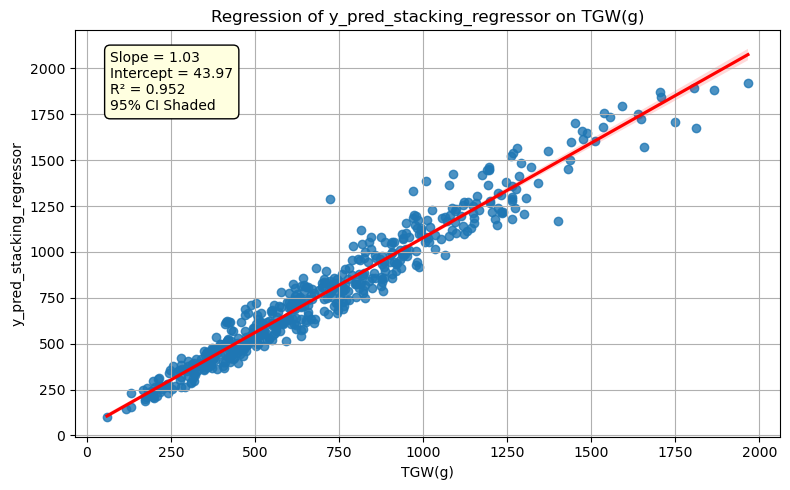

In [31]:
from statsmodels.stats.api import DescrStatsW
from scipy.stats import linregress

# Plot the regression
plot_regression_with_stats(df_t, 'TGW(g)', 'y_pred_stacking_regressor')


In [32]:
df_t.head(10)

,ID,TGW(g),y_pred_stacking_regressor
0,Vf1-1-2,1221.925000,1241.054794
1,Vf4-1-1,321.933333,329.256711
2,Vf7-1-1,356.810000,399.031201
3,Vf8-1-1,433.155556,445.124574
4,Vf9-1-1,456.450000,468.898144
5,Vf11-1-1,349.620000,359.718720
6,Vf13-1-1,822.450000,773.942332
7,Vf15-1-1,622.560000,639.158812
8,Vf16-1-1,706.714286,744.976002
9,Vf18-1-1,311.280000,360.119200


## Results: 
The regression analysis revealed a strong linear relationship between the predicted and actual thousand grain weight (TGW), as described by the equation: Predicted TGW (g) = 1.03 × Actual TGW (g) + 44.17. The model achieved a high coefficient of determination (R² = 0.952), indicating that 95.3% of the variance in the actual TGW is explained by the model’s predictions. The slope of 1.03 suggests that the model's predictions scale closely with the actual values, demonstrating good proportional accuracy. The intercept of 40.88 indicates the model's baseline prediction when the actual TGW is zero. Additionally, the 95% confidence interval, visually represented as a shaded region, illustrates the uncertainty associated with the model’s predictions, providing insight into the reliability of the regression estimates. Overall, these results suggest that the model performs excellently in predicting TGW.

## Conclusion
Overall, the Stacking Regressor not only maintained but enhanced its predictive power on new data, making it a robust and accurate model choice, especially when performance is prioritized over computational efficiency.

In [33]:
df_t.describe()


,TGW(g),y_pred_stacking_regressor
count,536.000000,536.000000
mean,699.003950,766.133143
std,349.098483,369.614262
min,59.800000,99.040298
25%,427.925833,480.445815
50%,635.083333,707.362867
75%,913.075000,996.114502
max,1966.166667,1919.211708


### Approach 2: Mass prediction analysis based on shape clusters and feature importance


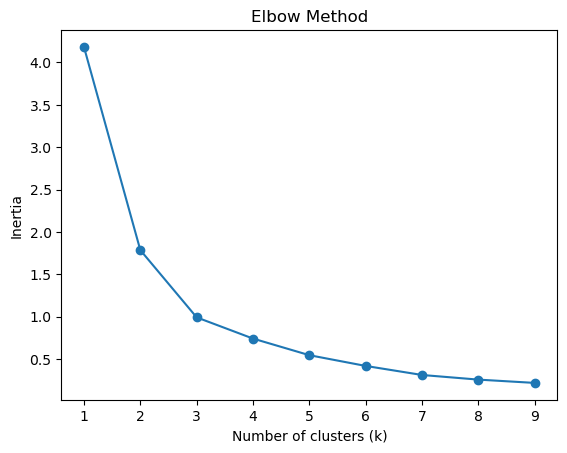

Global model CV RMSE: 11026.0669
Clustered models combined CV RMSE: 12905.0893
Paired t-test t=-2.081, p=0.0379
Cluster 0 - Ridge RMSE: 11544.6341, RF RMSE: 11859.6566


In [34]:
# Required imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_rel

# assume Mp1 exists and has the columns
X_all = Mp1[['ØArea', 'ØWidth', 'ØLength', 'ØCircularity', 'ØL/W Ratio']].copy()
y_all = Mp1['TGW(g)'].copy()

# 1) Cluster by shape using circularity and L/W ratio (you can choose number of clusters)
shape_features = X_all[['ØCircularity', 'ØL/W Ratio']].values


inertias = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(shape_features)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 3  # try 2 clusters first (round vs flat); you can try k=3,4 and validate
kmeans = KMeans(n_clusters=k, random_state=42)
shape_labels = kmeans.fit_predict(shape_features)
Mp1 = Mp1.copy()
Mp1['shape_cluster'] = shape_labels

# 2) Train a single global model (baseline)
global_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, random_state=42))
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# get cross-validated predictions for the global model
global_cv_preds = cross_val_predict(global_pipe, X_all, y_all, cv=cv)
global_rmse = mean_squared_error(y_all, global_cv_preds)
print(f"Global model CV RMSE: {global_rmse:.4f}")

# 3) Train cluster-specific models and get combined CV predictions
cluster_cv_preds = np.zeros_like(y_all.values, dtype=float)

# We'll do group-wise cross-validated predictions: for each cluster, run cross_val_predict on only that cluster
for cl in range(k):
    idx = Mp1.index[Mp1['shape_cluster'] == cl].tolist()
    X_cl = X_all.loc[idx]
    y_cl = y_all.loc[idx]
    if len(X_cl) < 10:
        # if too few samples, skip CV splitting (fit on all and predict)
        model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, random_state=42))
        model.fit(X_cl, y_cl)
        cluster_cv_preds[idx] = model.predict(X_cl)
    else:
        model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, random_state=42))
        # cross_val_predict returns predictions aligned with the subset indices
        preds_cl = cross_val_predict(model, X_cl, y_cl, cv=cv)
        cluster_cv_preds[idx] = preds_cl

cluster_rmse = mean_squared_error(y_all, cluster_cv_preds)
print(f"Clustered models combined CV RMSE: {cluster_rmse:.4f}")

# 4) Statistical test: are the global model errors significantly different from the clustered-model errors?
global_err = np.abs(y_all.values - global_cv_preds)
cluster_err = np.abs(y_all.values - cluster_cv_preds)

# paired t-test (or Wilcoxon if non-normal)
t_stat, p_val = ttest_rel(global_err, cluster_err)
print(f"Paired t-test t={t_stat:.3f}, p={p_val:.4f}")

# 5) If you want to compare model types inside each cluster, you can train different models per cluster.
# Example: linear vs RF in cluster 0
from sklearn.linear_model import Ridge
cl = 0
idx = Mp1.index[Mp1['shape_cluster'] == cl].tolist()
Xc = X_all.loc[idx]; yc = y_all.loc[idx]
pipe_lin = make_pipeline(StandardScaler(), Ridge())
pipe_rf  = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200, random_state=42))

preds_lin = cross_val_predict(pipe_lin, Xc, yc, cv=cv)
preds_rf  = cross_val_predict(pipe_rf,  Xc, yc, cv=cv)
rmse_lin = mean_squared_error(yc, preds_lin)
rmse_rf  = mean_squared_error(yc, preds_rf)
print(f"Cluster {cl} - Ridge RMSE: {rmse_lin:.4f}, RF RMSE: {rmse_rf:.4f}")


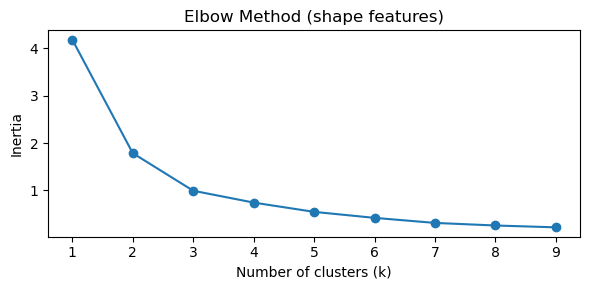

Running global CV for Linear ...
  Global Linear - RMSE: 103.1291, R2: 0.9125
Running global CV for RandomForest ...
  Global RandomForest - RMSE: 105.0051, R2: 0.9093
Running global CV for GradientBoosting ...
  Global GradientBoosting - RMSE: 106.6254, R2: 0.9065
Running global CV for Stacking ...
  Global Stacking - RMSE: 101.3750, R2: 0.9155

Running clustered CV for Linear ...
  Clustered Linear combined - RMSE: 106.1185, R2: 0.9074

Running clustered CV for RandomForest ...
  Clustered RandomForest combined - RMSE: 113.6006, R2: 0.8939

Running clustered CV for GradientBoosting ...
  Clustered GradientBoosting combined - RMSE: 118.0054, R2: 0.8855

Running clustered CV for Stacking ...
  Clustered Stacking combined - RMSE: 108.4409, R2: 0.9033

Paired t-tests (abs errors):
  Linear: t=-1.432, p=0.1526
  RandomForest: t=-2.081, p=0.0379
  GradientBoosting: t=-2.335, p=0.0199
  Stacking: t=-2.577, p=0.0102

Fitting full-data Linear for global feature importance ...

Fitting full-da

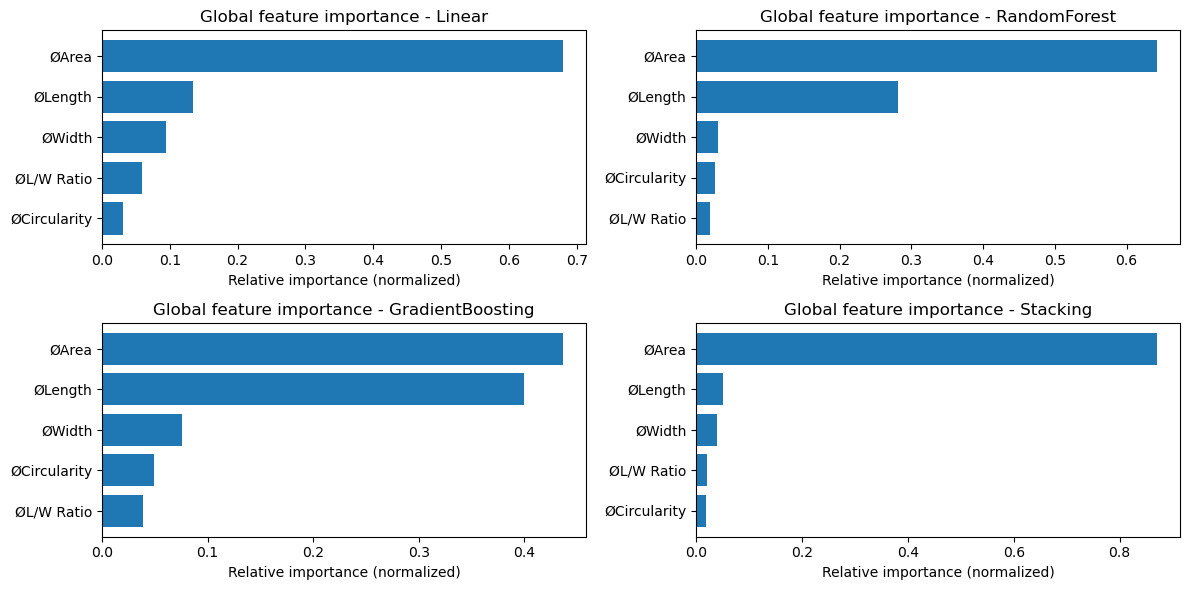

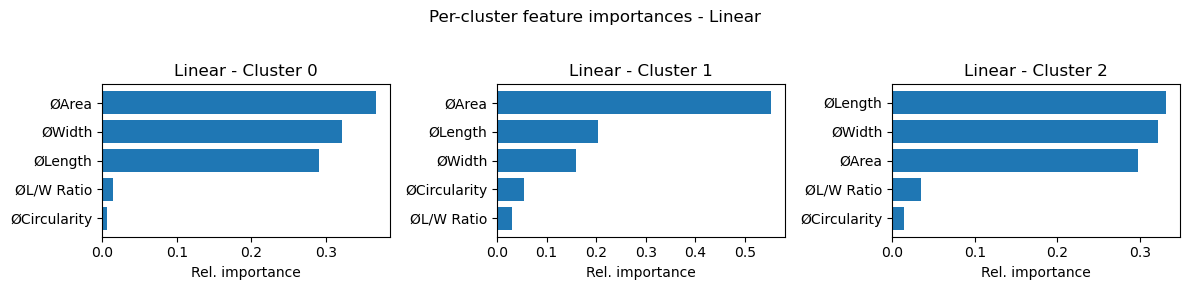

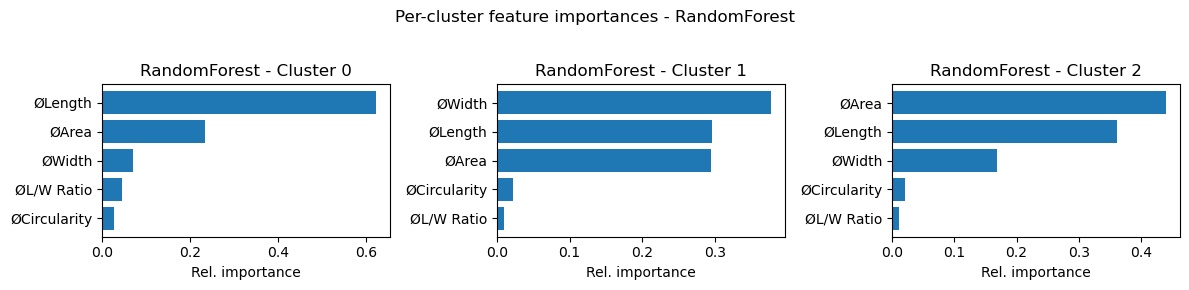

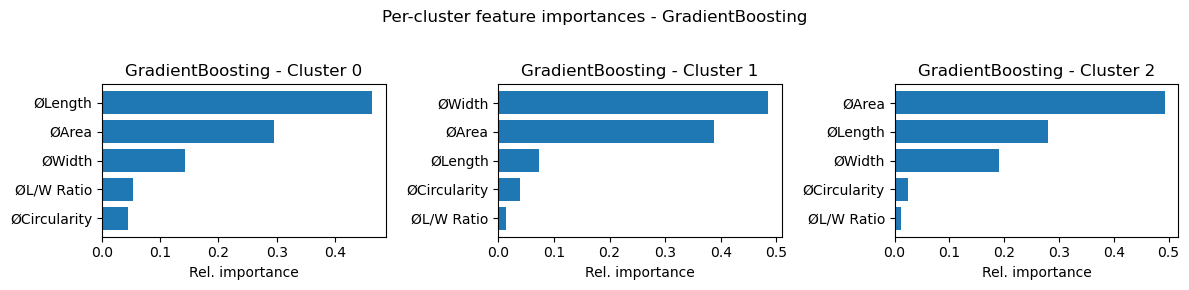

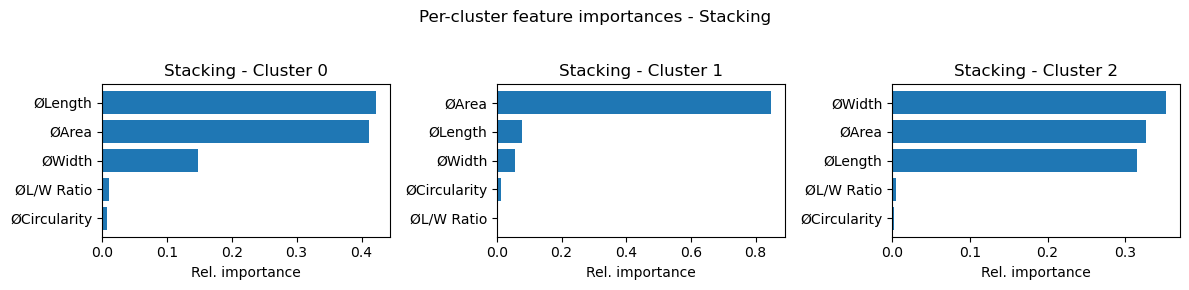


Summary metrics:
              Model      Scope        RMSE        R2
0  GradientBoosting  Clustered  118.005431  0.885475
1  GradientBoosting     Global  106.625396  0.906499
2            Linear  Clustered  106.118487  0.907386
3            Linear     Global  103.129108  0.912530
4      RandomForest  Clustered  113.600569  0.893865
5      RandomForest     Global  105.005080  0.909319
6          Stacking  Clustered  108.440915  0.903287
7          Stacking     Global  101.374988  0.915480


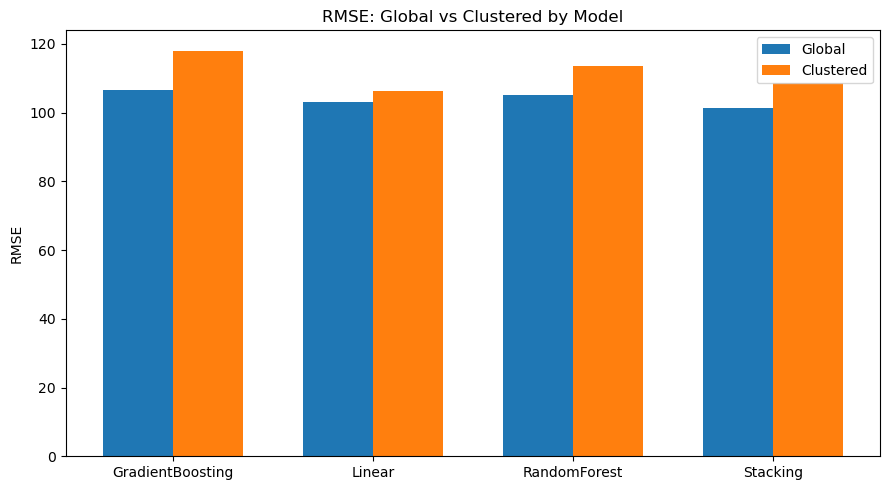

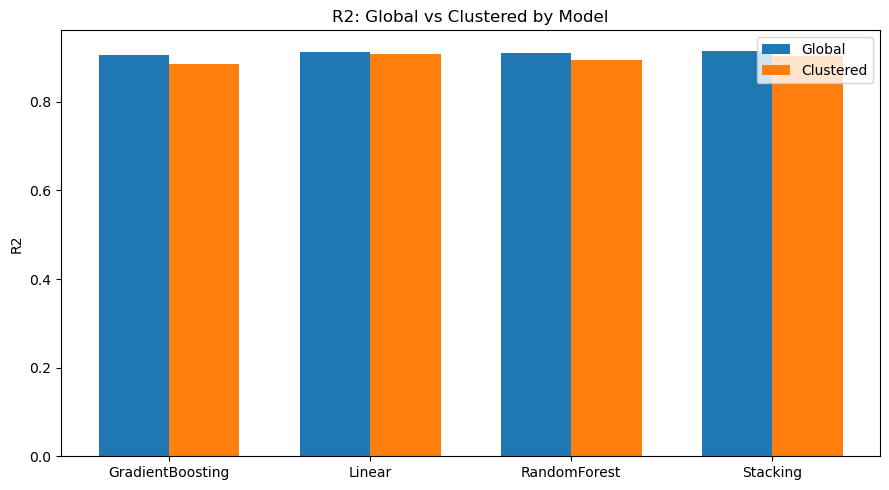

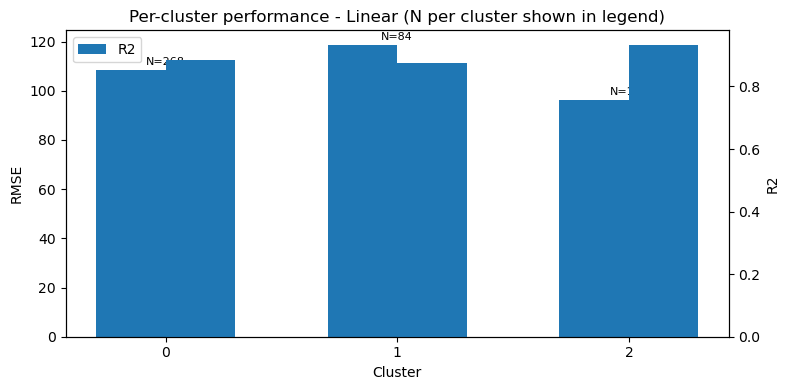

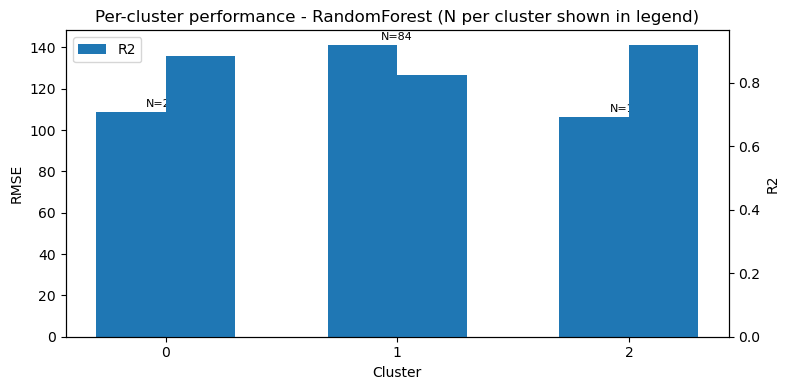

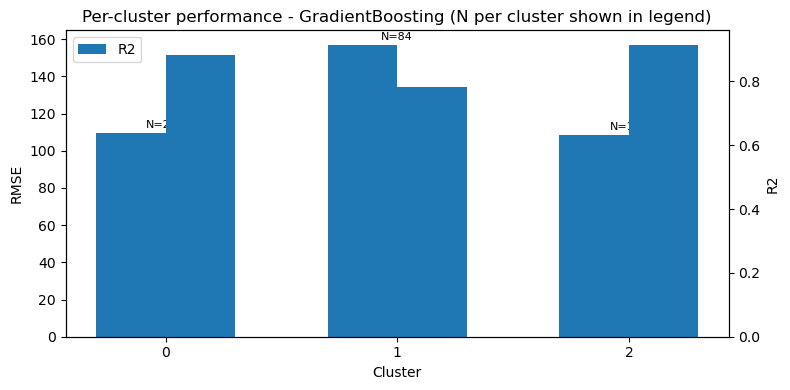

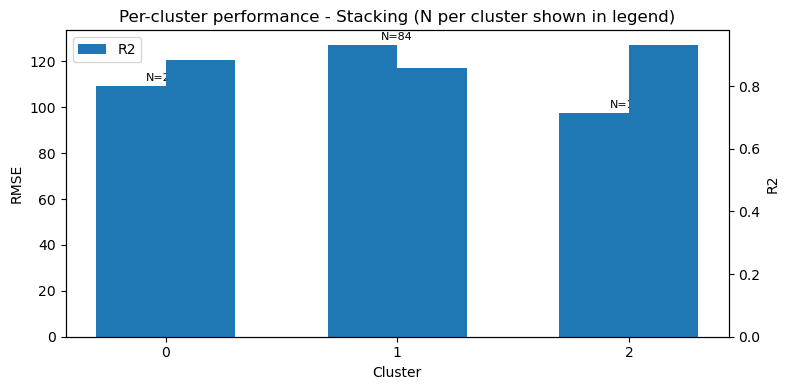


Paired test summary (global vs clustered) per model:
  Linear: t=-1.432, p=0.1526
  RandomForest: t=-2.081, p=0.0379
  GradientBoosting: t=-2.335, p=0.0199
  Stacking: t=-2.577, p=0.0102

Finished. Inspect the plots and the summary_df table for comparisons. Rows with lower RMSE and higher R² are better.


In [35]:
# Exhaustive modelling + cluster vs global + feature importance + metrics table + plots
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from itertools import product

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel

# -------------------------
# User-adjustable settings
# -------------------------
RANDOM_STATE = 42
N_ESTIMATORS = 200
CV_FOLDS = 5
K_CLUSTERS = 3  # number of shape clusters (user used 3)
MIN_SAMPLES_FOR_CV = 10  # if cluster has less than this, we fit on all and predict (no CV split)

# -------------------------
# Prepare data (assumes Mp1 exists)
# -------------------------
# Columns used (from user's snippet)
feature_cols = ['ØArea', 'ØWidth', 'ØLength', 'ØCircularity', 'ØL/W Ratio']
target_col = 'TGW(g)'

# Basic check - adjust or raise clear error
assert 'Mp1' in globals() or 'Mp1' in locals(), "DataFrame Mp1 not found in the environment."
Mp1 = Mp1.copy()  # work on a copy
X_all = Mp1[feature_cols].copy()
y_all = Mp1[target_col].copy()

# -------------------------
# 1) Cluster by shape (ØCircularity, ØL/W Ratio) and attach labels
# -------------------------
shape_features = X_all[['ØCircularity', 'ØL/W Ratio']].values

inertias = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    km.fit(shape_features)
    inertias.append(km.inertia_)

# Optional elbow plot (uncomment if running interactively)
plt.figure(figsize=(6, 3))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (shape features)')
plt.tight_layout()
plt.show()

# Fit final k-means
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_STATE)
Mp1['shape_cluster'] = kmeans.fit_predict(shape_features)
shape_labels = Mp1['shape_cluster'].values

# -------------------------
# 2) Define model factory
# -------------------------
def make_models(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS):
    # return a dict of name -> sklearn estimator or pipeline
    models = {}
    models['Linear'] = make_pipeline(StandardScaler(), LinearRegression())
    models['RandomForest'] = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=n_estimators, random_state=random_state))
    models['GradientBoosting'] = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state))
    # stacking: base learners (without scaling inside base because pipeline wraps all) - but we'll stack pipelines
    estimators = [
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)),
        ('gb', GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state))
    ]
    stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=CV_FOLDS, n_jobs=-1, passthrough=False)
    # wrap stacking with StandardScaler for inputs
    models['Stacking'] = make_pipeline(StandardScaler(), stack)
    return models

models = make_models()

# -------------------------
# 3) Cross-validated predictions and metrics for GLOBAL models
# -------------------------
cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

global_cv_preds = {}
global_metrics = {}
for name, model in models.items():
    print(f"Running global CV for {name} ...")
    preds = cross_val_predict(model, X_all, y_all, cv=cv, n_jobs=-1)
    global_cv_preds[name] = preds
    rmse = sqrt(mean_squared_error(y_all, preds))
    r2 = r2_score(y_all, preds)
    global_metrics[name] = {'RMSE': rmse, 'R2': r2}
    print(f"  Global {name} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 4) Cluster-specific models: get per-cluster CV predictions and combined metrics
# -------------------------
cluster_cv_preds_by_model = {name: np.zeros(len(Mp1), dtype=float) for name in models.keys()}
cluster_metrics = {name: {} for name in models.keys()}

for name, base_model in models.items():
    print(f"\nRunning clustered CV for {name} ...")
    combined_preds = np.zeros(len(Mp1), dtype=float)
    for cl in sorted(Mp1['shape_cluster'].unique()):
        idx = Mp1.index[Mp1['shape_cluster'] == cl].tolist()
        Xc = X_all.loc[idx]
        yc = y_all.loc[idx]
        if len(Xc) == 0:
            continue
        # If too small, fit on all cluster samples and predict (no CV)
        if len(Xc) < MIN_SAMPLES_FOR_CV:
            print(f"  Cluster {cl} small (n={len(Xc)}) - fitting on all samples")
            fitted = base_model.fit(Xc, yc)
            preds_cl = fitted.predict(Xc)
            combined_preds[idx] = preds_cl
        else:
            preds_cl = cross_val_predict(base_model, Xc, yc, cv=cv, n_jobs=-1)
            combined_preds[idx] = preds_cl
    cluster_cv_preds_by_model[name] = combined_preds
    rmse = sqrt(mean_squared_error(y_all, combined_preds))
    r2 = r2_score(y_all, combined_preds)
    cluster_metrics[name] = {'RMSE': rmse, 'R2': r2}
    print(f"  Clustered {name} combined - RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------
# 5) Paired comparison tests (global vs clustered)
# -------------------------
print("\nPaired t-tests (abs errors):")
paired_test_results = {}
for name in models.keys():
    global_err = np.abs(y_all.values - global_cv_preds[name])
    cluster_err = np.abs(y_all.values - cluster_cv_preds_by_model[name])
    try:
        t_stat, p_val = ttest_rel(global_err, cluster_err)
    except Exception as e:
        t_stat, p_val = np.nan, np.nan
    paired_test_results[name] = {'t_stat': t_stat, 'p_val': p_val}
    print(f"  {name}: t={t_stat:.3f}, p={p_val:.4f}")

# -------------------------
# 6) Feature importance
# Approach:
# - For Linear: absolute coefficients (from a model fitted on all data)
# - For RF / GB / Stacking: permutation importance (fitted on all data)
# For per-cluster importances: fit on cluster data (if cluster has enough samples), otherwise skip.
# -------------------------
def compute_feature_importances(model_pipeline, X, y, feature_names, random_state=RANDOM_STATE, n_repeats=30):
    """
    Returns importance Series indexed by feature_names.
    model_pipeline: fitted sklearn pipeline (not cross-validated predictions)
    """
    # For linear pipeline where final is LinearRegression, we can extract coefficients
    # We'll check if the final estimator has coef_
    # Otherwise use permutation_importance on the fitted pipeline
    # Note: permutation_importance expects a fitted estimator with predict method.
    try:
        final = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[-1]]
    except Exception:
        final = None

    # Try coefficient extraction
    if hasattr(final, 'coef_') and final.coef_.ndim == 1:
        # If pipeline includes StandardScaler, the coefficients are in scaled space;
        # We can get them directly but to make them comparable we take absolute value and normalize
        coefs = final.coef_
        imp = pd.Series(np.abs(coefs), index=feature_names)
        imp = imp / imp.sum()
        return imp
    else:
        # Permutation importance
        # Note: permutation_importance works on the entire pipeline
        res = permutation_importance(model_pipeline, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=-1, scoring='neg_mean_squared_error')
        imp = pd.Series(res.importances_mean, index=feature_names)
        # Normalize to sum to 1 for comparability
        if imp.sum() != 0:
            imp = imp / imp.sum()
        return imp

# Fit each model on full dataset for global feature importance
fitted_global_models = {}
global_importances = {}
for name, model in models.items():
    print(f"\nFitting full-data {name} for global feature importance ...")
    fitted = model.fit(X_all, y_all)
    fitted_global_models[name] = fitted
    imp = compute_feature_importances(fitted, X_all, y_all, feature_cols)
    global_importances[name] = imp

# Per-cluster feature importances (store in dict of dicts)
cluster_importances = {name: {} for name in models.keys()}
for name, model in models.items():
    for cl in sorted(Mp1['shape_cluster'].unique()):
        idx = Mp1.index[Mp1['shape_cluster'] == cl].tolist()
        Xc = X_all.loc[idx]
        yc = y_all.loc[idx]
        if len(Xc) < 6:
            # too small to estimate importance reliably
            cluster_importances[name][cl] = None
            print(f"Skipping importance for {name} cluster {cl} (n={len(Xc)}) - too few samples")
            continue
        print(f"Fitting {name} on cluster {cl} (n={len(Xc)}) for importance ...")
        fitted = model.fit(Xc, yc)
        imp = compute_feature_importances(fitted, Xc, yc, feature_cols)
        cluster_importances[name][cl] = imp

# -------------------------
# 7) Plotting - feature importances global (one figure per model)
# -------------------------
import math
num_models = len(models)
plt.style.use('default')

# Global importances: one subplot per model
fig, axes = plt.subplots(nrows=math.ceil(num_models/2), ncols=2, figsize=(12, 3*math.ceil(num_models/2)))
axes = axes.flatten()
for ax, (name, imp) in zip(axes, global_importances.items()):
    imp_sorted = imp.sort_values(ascending=True)
    ax.barh(imp_sorted.index, imp_sorted.values)
    ax.set_title(f'Global feature importance - {name}')
    ax.set_xlabel('Relative importance (normalized)')
plt.tight_layout()
plt.show()

# Per-cluster importances: for each model, make a grid of clusters
for name in models.keys():
    cl_keys = sorted(cluster_importances[name].keys())
    ncols = min(len(cl_keys), 3)
    nrows = math.ceil(len(cl_keys) / ncols) if ncols>0 else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))
    axes = np.array(axes).reshape(-1)
    plotted = False
    for ax_idx, cl in enumerate(cl_keys):
        imp = cluster_importances[name][cl]
        ax = axes[ax_idx]
        if imp is None:
            ax.text(0.5, 0.5, f'Cluster {cl}\n(n too small)', ha='center', va='center')
            ax.set_axis_off()
            continue
        imp_sorted = imp.sort_values(ascending=True)
        ax.barh(imp_sorted.index, imp_sorted.values)
        ax.set_title(f'{name} - Cluster {cl}')
        ax.set_xlabel('Rel. importance')
        plotted = True
    # Hide any unused axes
    for j in range(len(cl_keys), len(axes)):
        axes[j].set_visible(False)
    plt.suptitle(f'Per-cluster feature importances - {name}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -------------------------
# 8) RMSE and R2 summary table + plots
# -------------------------
rows = []
for name in models.keys():
    # global
    rows.append({
        'Model': name,
        'Scope': 'Global',
        'RMSE': global_metrics[name]['RMSE'],
        'R2': global_metrics[name]['R2']
    })
    # clustered
    rows.append({
        'Model': name,
        'Scope': 'Clustered',
        'RMSE': cluster_metrics[name]['RMSE'],
        'R2': cluster_metrics[name]['R2']
    })

summary_df = pd.DataFrame(rows)
# Nice ordering
summary_df = summary_df[['Model', 'Scope', 'RMSE', 'R2']].sort_values(['Model', 'Scope']).reset_index(drop=True)
print("\nSummary metrics:")
print(summary_df)

# Barplot: RMSE grouped by model and scope
fig, ax = plt.subplots(figsize=(9,5))
models_list = summary_df['Model'].unique()
x = np.arange(len(models_list))
width = 0.35
global_rmse = summary_df[summary_df['Scope']=='Global'].set_index('Model').loc[models_list]['RMSE'].values
cluster_rmse = summary_df[summary_df['Scope']=='Clustered'].set_index('Model').loc[models_list]['RMSE'].values

ax.bar(x - width/2, global_rmse, width, label='Global')
ax.bar(x + width/2, cluster_rmse, width, label='Clustered')
ax.set_xticks(x)
ax.set_xticklabels(models_list)
ax.set_ylabel('RMSE')
ax.set_title('RMSE: Global vs Clustered by Model')
ax.legend()
plt.tight_layout()
plt.show()

# Barplot: R2 grouped by model and scope
fig, ax = plt.subplots(figsize=(9,5))
global_r2 = summary_df[summary_df['Scope']=='Global'].set_index('Model').loc[models_list]['R2'].values
cluster_r2 = summary_df[summary_df['Scope']=='Clustered'].set_index('Model').loc[models_list]['R2'].values

ax.bar(x - width/2, global_r2, width, label='Global')
ax.bar(x + width/2, cluster_r2, width, label='Clustered')
ax.set_xticks(x)
ax.set_xticklabels(models_list)
ax.set_ylabel('R2')
ax.set_title('R2: Global vs Clustered by Model')
ax.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 9) Per-cluster performance plots (for each model, show cluster-wise RMSE & R2)
# -------------------------
for name, base_model in models.items():
    cluster_rows = []
    for cl in sorted(Mp1['shape_cluster'].unique()):
        idx = Mp1.index[Mp1['shape_cluster'] == cl].tolist()
        Xc = X_all.loc[idx]
        yc = y_all.loc[idx]
        if len(Xc) < 4:
            cluster_rows.append({'cluster': cl, 'RMSE': np.nan, 'R2': np.nan, 'N': len(Xc)})
            continue
        # Evaluate using CV where possible
        if len(Xc) < MIN_SAMPLES_FOR_CV:
            preds = base_model.fit(Xc, yc).predict(Xc)
        else:
            preds = cross_val_predict(base_model, Xc, yc, cv=cv, n_jobs=-1)
        rmse = sqrt(mean_squared_error(yc, preds))
        r2 = r2_score(yc, preds)
        cluster_rows.append({'cluster': cl, 'RMSE': rmse, 'R2': r2, 'N': len(Xc)})

    cluster_perf = pd.DataFrame(cluster_rows)
    # Plot
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.bar(cluster_perf['cluster'] - 0.15, cluster_perf['RMSE'], width=0.3, label='RMSE')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('RMSE')
    ax1.set_xticks(cluster_perf['cluster'])
    ax2 = ax1.twinx()
    ax2.bar(cluster_perf['cluster'] + 0.15, cluster_perf['R2'], width=0.3, label='R2')
    ax2.set_ylabel('R2')
    plt.title(f'Per-cluster performance - {name} (N per cluster shown in legend)')
    # add legend with N counts
    plt.legend(loc='upper left')
    # annotate N
    for i, row in cluster_perf.iterrows():
        ax1.text(row['cluster'], row['RMSE'] + 0.01 * (cluster_perf['RMSE'].max() or 1), f"N={int(row['N'])}", ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# -------------------------
# 10) Optionally save summary table
# -------------------------
# summary_df.to_csv('model_summary_metrics.csv', index=False)

# -------------------------
# 11) Print final recommendations (simple)
# -------------------------
print("\nPaired test summary (global vs clustered) per model:")
for name, r in paired_test_results.items():
    print(f"  {name}: t={r['t_stat']:.3f}, p={r['p_val']:.4f}")
print("\nFinished. Inspect the plots and the summary_df table for comparisons. Rows with lower RMSE and higher R² are better.")


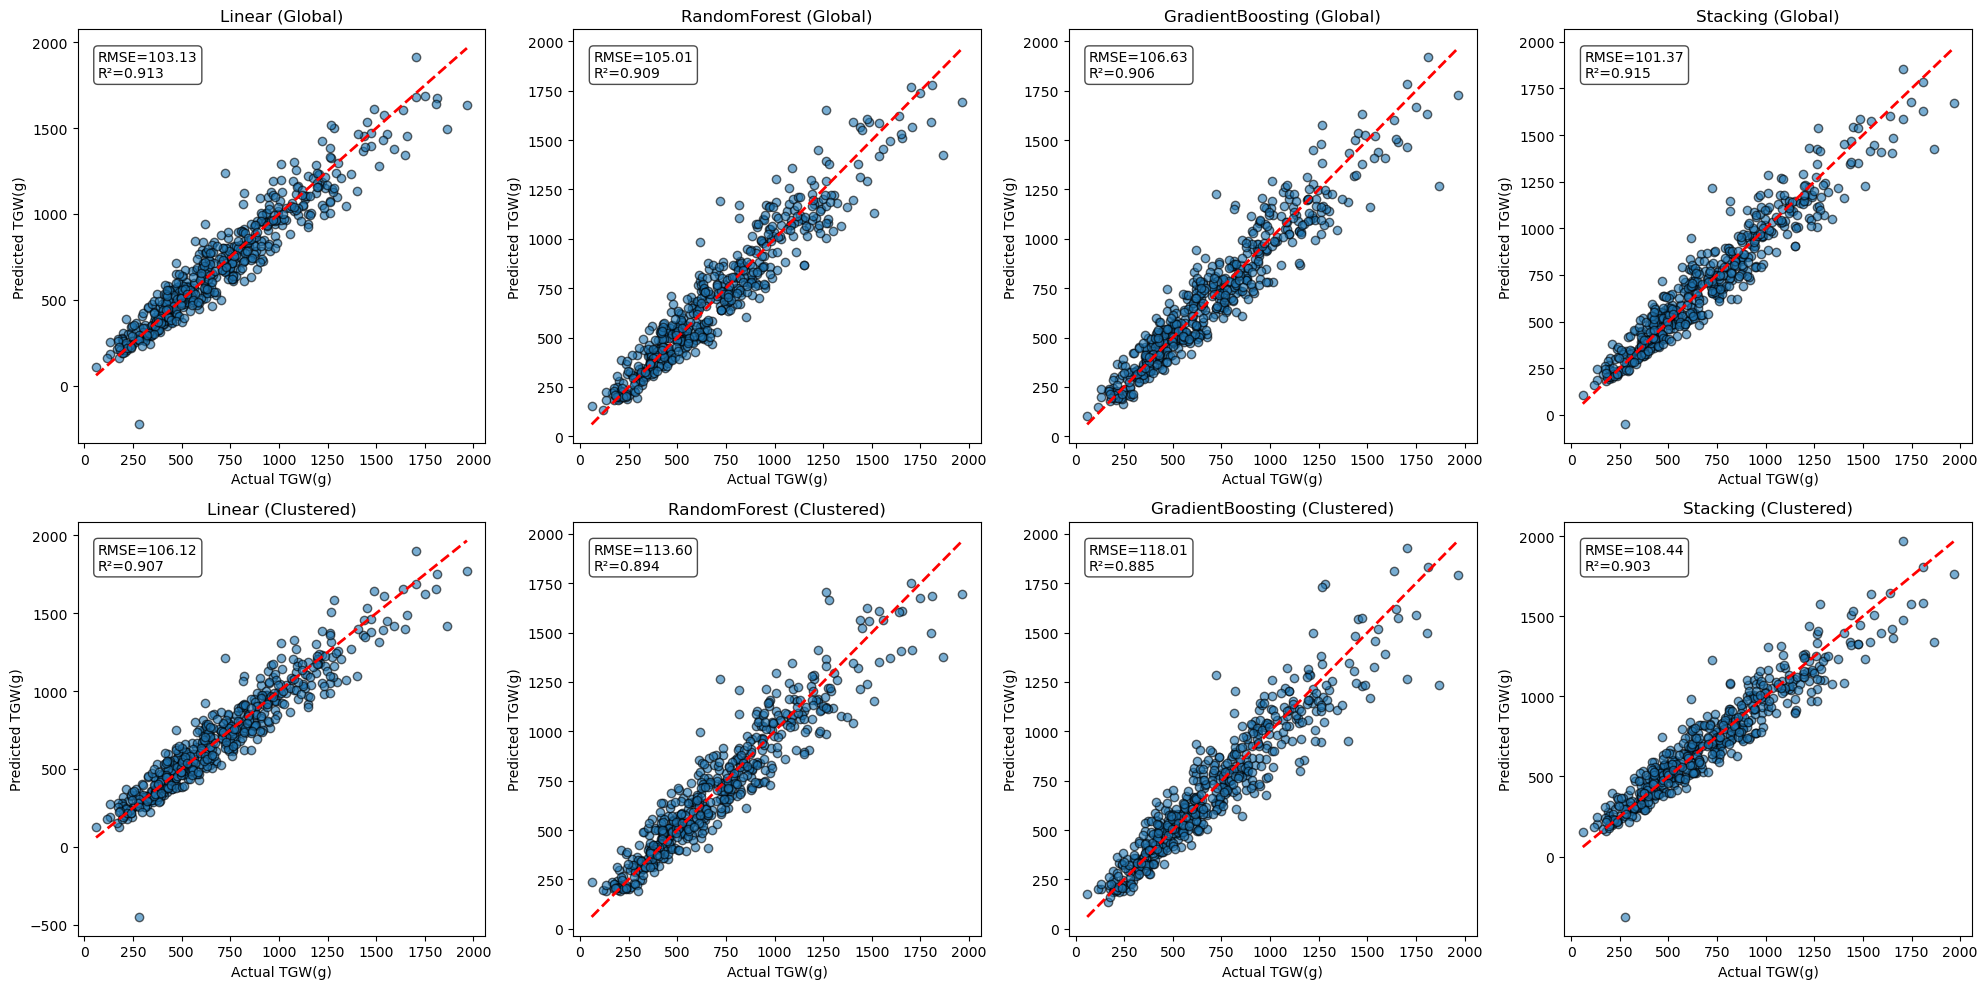

In [36]:
# -------------------------
# 13) Combined Predicted vs Actual plots (2 rows x 4 columns)
# -------------------------
import matplotlib.pyplot as plt

# Prepare data
all_models = list(models.keys())
scopes = ['Global', 'Clustered']
pred_dict = {'Global': global_cv_preds, 'Clustered': cluster_cv_preds_by_model}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (scope, model_name) in enumerate(product(scopes, all_models)):
    ax = axes[i]
    preds = pred_dict[scope][model_name]
    y_true = y_all.values
    
    # Scatter plot
    ax.scatter(y_true, preds, alpha=0.6, edgecolors='k')
    # 1:1 reference line
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    
    # Compute metrics
    rmse = sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    
    # Annotate metrics inside plot
    ax.text(0.05, 0.95, f'RMSE={rmse:.2f}\nR²={r2:.3f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.set_title(f'{model_name} ({scope})')
    ax.set_xlabel('Actual TGW(g)')
    ax.set_ylabel('Predicted TGW(g)')

plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

for name, model in models.items():
    # Fit model on all training data
    model.fit(X_all, y_all)
    
    # Training predictions
    train_preds = model.predict(X_all)
    train_rmse = sqrt(mean_squared_error(y_all, train_preds))
    train_r2 = r2_score(y_all, train_preds)
    
    # Validation (CV) predictions
    val_preds = global_cv_preds[name]
    val_rmse = sqrt(mean_squared_error(y_all, val_preds))
    val_r2 = r2_score(y_all, val_preds)
    
    print(f"{name} - Training: RMSE={train_rmse:.2f}, R²={train_r2:.3f} | CV: RMSE={val_rmse:.2f}, R²={val_r2:.3f}")


Linear - Training: RMSE=100.06, R²=0.918 | CV: RMSE=103.13, R²=0.913
RandomForest - Training: RMSE=38.92, R²=0.988 | CV: RMSE=105.01, R²=0.909
GradientBoosting - Training: RMSE=48.36, R²=0.981 | CV: RMSE=106.63, R²=0.906
Stacking - Training: RMSE=66.40, R²=0.964 | CV: RMSE=101.37, R²=0.915


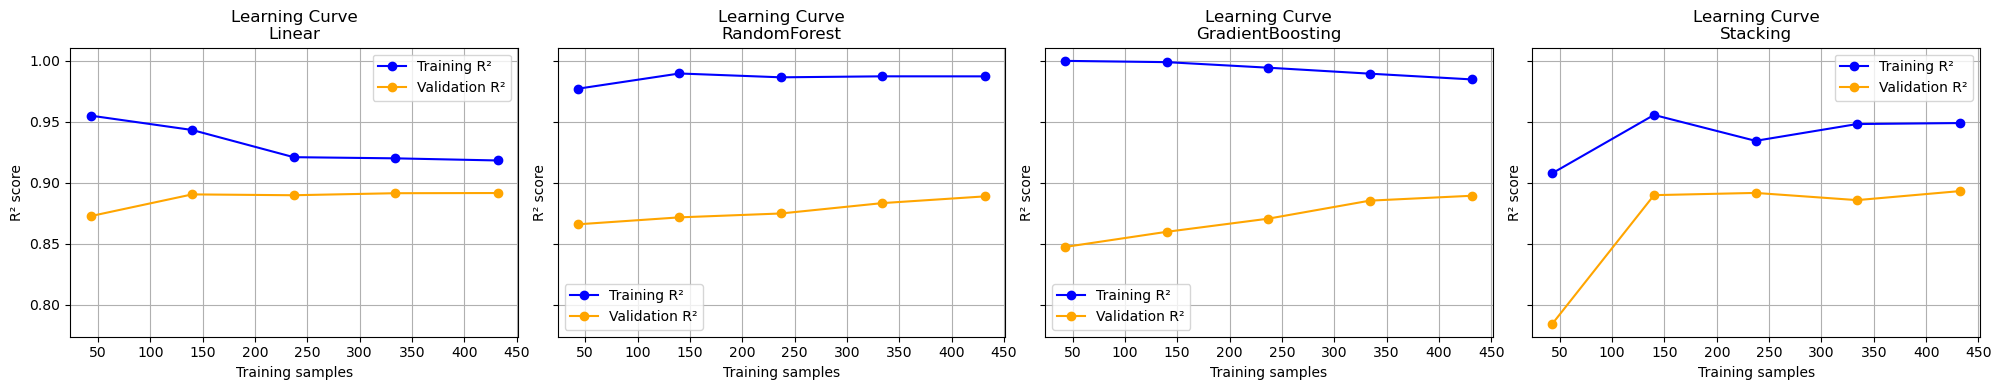

In [38]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Set up figure with 1 row, N columns (N = number of models)
num_models = len(models)
fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 4), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_all, y_all, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
    ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation R²')
    ax.set_title(f'Learning Curve\n{name}')
    ax.set_xlabel('Training samples')
    ax.set_ylabel('R² score')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## Training on stacking regressor and prediction using linear regressor on trained stacking regressor model

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

#read the .csv file for SAM2.1 data
SAM_2=pd.read_csv(r"C:\Users\bargotah\Downloads\output_nov27\FE_Color.csv")

# Example: trained stacking regressor pipeline
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=200, random_state=42))
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    passthrough=False
)

# Wrap with scaling if needed
model_pipeline = make_pipeline(StandardScaler(), stack)

Mp2=Mp1.copy()
# Renaming columns
Mp2.rename(columns={'ØArea': 'Area-SAM(mm2)', 'ØWidth': 'Width-SAM(mm)', 'ØLength': 'Length-SAM(mm)', 'ØCircularity': 'Circularity-SAM', 'ØL/W Ratio': 'Aspect Ratio'}, inplace=True)
Mp2.info()
# Train on your data
X_train = Mp2[['Area-SAM(mm2)', 'Width-SAM(mm)', 'Length-SAM(mm)', 'Circularity-SAM', 'Aspect Ratio']]
y_train = Mp2['TGW(g)']
model_pipeline.fit(X_train, y_train)

# Predict TGW for the same or new data
X_new = SAM_2[['Area-SAM(mm2)', 'Width-SAM(mm)', 'Length-SAM(mm)', 'Circularity-SAM', 'Aspect Ratio']]
SAM_2['TGW_pred'] = model_pipeline.predict(X_new)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               541 non-null    object 
 1   Main Seeds       541 non-null    int64  
 2   Weight(g)        541 non-null    float64
 3   TGW(g)           541 non-null    float64
 4   Seeds/kg         541 non-null    float64
 5   Area-SAM(mm2)    541 non-null    float64
 6   Width-SAM(mm)    541 non-null    float64
 7   Length-SAM(mm)   541 non-null    float64
 8   Min Width        541 non-null    float64
 9   Min Length       541 non-null    float64
 10  Max Width        541 non-null    float64
 11  Max Length       541 non-null    float64
 12  Circularity-SAM  541 non-null    float64
 13  Min Circularity  541 non-null    float64
 14  Max Circularity  541 non-null    float64
 15  Aspect Ratio     541 non-null    float64
 16  Min L/W Ratio    541 non-null    float64
 17  Max L/W Ratio   

In [40]:
# Generate stacking predictions on training data
stack_preds = model_pipeline.predict(X_train)

# Fit linear regression to approximate formula
lin_approx = LinearRegression()
lin_approx.fit(X_train, stack_preds)

# Get coefficients
coeffs = pd.Series(lin_approx.coef_, index=X_train.columns)
intercept = lin_approx.intercept_

print("TGW ≈", intercept, "+", " + ".join(f"{c:.4f}*{f}" for f, c in coeffs.items()))


TGW ≈ 296.9785397519971 + 5.5020*Area-SAM(mm2) + 18.4537*Width-SAM(mm) + -17.3898*Length-SAM(mm) + -607.6333*Circularity-SAM + 344.1165*Aspect Ratio


In [41]:
SAM_2['TGW(g)'] = (
    296.9785397519971
    + (5.5020 * SAM_2['Area-SAM(mm2)'])
    + (18.4537 * SAM_2['Width-SAM(mm)'])
    + (-17.3898 * SAM_2['Length-SAM(mm)'])
    + (-607.6333 * SAM_2['Circularity-SAM'])
    + (344.1165 * SAM_2['Aspect Ratio'])
)

In [42]:
SAM_2.head(5)

,Seed No. per image,Class,Area-SAM(mm2),Length-SAM(mm),Width-SAM(mm),Perimeter-SAM(mm),Area-SAM_taubin(mm2),Length-SAM_taubin(mm),Width-SAM_taubin(mm),Perimeter-SAM_taubin(mm),...,Circularity-SAM,Shape,Shapefactor1,Shapefactor2,Shapefactor3,Shapefactor4,RGB value of Seed,color_seeds,TGW_pred,TGW(g)
0,0,Faba-Seed-CC_Vf447-1-1,96.047573,11.248159,10.770226,34.610325,94.820851,12.447068,9.756425,37.090704,...,1.154560,"Elongated,Oval,Elongated,Ellipse",0.005105,0.004002,0.779255,0.994160,"[255, 247, 48]",yellow,538.515283,566.048100
1,1,Faba-Seed-CC_Vf447-1-1,90.111920,10.808319,10.496649,33.291382,88.961008,11.960346,9.508600,35.677237,...,1.138604,"Elongated,Oval,Elongated,Ellipse",0.005229,0.004157,0.791812,0.995977,"[247, 239, 40]",yellow,530.253281,539.513140
2,2,Faba-Seed-CC_Vf447-1-1,89.888222,10.875486,10.374126,33.395540,88.740168,12.034672,9.397610,35.788860,...,1.148592,"Elongated,Oval,Elongated,Ellipse",0.005274,0.004119,0.780121,0.999030,"[255, 255, 41]",yellow,528.676564,536.618543
3,3,Faba-Seed-CC_Vf447-1-1,94.993436,11.658823,10.245933,34.515858,93.780177,12.901503,9.281484,36.989466,...,1.161008,"Elongated,Oval,Elongated,Ellipse",0.005350,0.003849,0.717366,0.997157,"[243, 231, 33]",gold,570.564358,578.826934
4,4,Faba-Seed-CC_Vf447-1-1,103.469438,11.352529,11.508256,35.859708,102.147924,12.562562,10.424985,38.429625,...,1.150517,"Elongated,Oval,Elongated,Ellipse",0.004783,0.003969,0.824106,0.993084,"[255, 242, 39]",yellow,547.384442,596.802336
